A notebook where we synthesize regression models, when the true systems have an m function which is a Quadratic surface.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import math

import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.extra_torch_modules import DenseLNLNet
from janelia_core.ml.extra_torch_modules import QuadSurf
from janelia_core.ml.utils import list_torch_devices

from probabilistic_model_synthesis.gaussian_nonlinear_regression import compare_weight_prior_dists
from probabilistic_model_synthesis.gaussian_nonlinear_regression import align_low_d_spaces
from probabilistic_model_synthesis.gaussian_nonlinear_regression import fit_with_hypercube_priors
from probabilistic_model_synthesis.gaussian_nonlinear_regression import Fitter
from probabilistic_model_synthesis.gaussian_nonlinear_regression import generate_hypercube_prior_collection
from probabilistic_model_synthesis.gaussian_nonlinear_regression import GNLRMdl
from probabilistic_model_synthesis.simulation import generate_sum_of_bump_fcns_dist
from probabilistic_model_synthesis.simulation import sample_proj_data_from_cone
from probabilistic_model_synthesis.visualization import assign_colors_to_pts
from probabilistic_model_synthesis.visualization import plot_three_dim_pts

In [3]:
%matplotlib notebook

## Parameters go here

In [4]:
# Range of the number of input variables we observe from each individual - the actual number of variables we 
# observe from an individual will be pulled uniformly from this range (inclusive)
n_input_var_range = [10000, 11000]

# Range of the number of samples we observe from each individual - the actual number we observe from each individual
# will be unformly from this range (inclusive)
n_smps_range = [12000, 15000]

# ===============================================================================================
# Parameters for the true priors 

true_hc_params = {'n_divisions_per_dim': [10, 10], 
                  'dim_ranges': np.asarray([[-.1, 1.1],
                                       [-.1, 1.1]]),
                   'n_div_per_hc_side_per_dim': [1, 1]}

# The full options for setting up the prior on weights
true_w_prior_opts = {'mn_hc_params': true_hc_params, 'std_hc_params': true_hc_params, 
                     'min_std': .000001, 'mn_init': 0.0, 'std_init': .3}

# Options for the prior distributions on the scales, biases and psi
true_s_in_prior_opts = {'mn_mn': 1.0/np.sqrt(n_input_var_range[0]), 'mn_std': .00000001, 
                     'std_iv': .00001, 'std_lb': .0000001}

true_s_out_prior_opts = {'mn_mn': 1.0, 'mn_std': .00000001, 
                     'std_iv': .00001, 'std_lb': .0000001}

true_b_prior_opts = {'mn_mn': 0.0, 'mn_std': .00000001, 'std_iv': .001}
true_psi_prior_opts = {'conc_iv': 10.0, 'rate_iv': 1000.0, 'rate_ub': 10000.0}

# Parameters for generating shared m-module we use for fitting
m_n_layers = 5 #2
m_growth_rate = 5 #2

# Specify the number of intermediate variables and number of variables we predict
p = 2
d_pred = 3

# ===============================================================================================
# Parameters for the fit models

# The full options for setting up the prior on weights
fit_hc_params = {'n_divisions_per_dim': [80, 80], 
                 'dim_ranges': np.asarray([[-.1, 1.1],
                                       [-.1, 1.1]]),
                 'n_div_per_hc_side_per_dim': [1, 1]}

# The full options for setting up the prior on weights
fit_w_prior_opts = {'mn_hc_params': fit_hc_params, 'std_hc_params': fit_hc_params, 
                     'min_std': .000001, 'mn_init': 0.0, 'std_init': .3}

# Options for the prior distributions on the scales, biases and psi
fit_s_in_prior_opts = true_s_in_prior_opts
fit_s_out_prior_opts = true_s_out_prior_opts
fit_b_prior_opts = true_b_prior_opts
fit_psi_prior_opts = true_psi_prior_opts

# Options for posterior distribtions 
s_in_post_opts = {'mn_mn': 1.0/np.sqrt(n_input_var_range[0]), 'mn_std': .000001, 
               'std_iv': .00001, 'std_lb': .0000001}
s_out_post_opts = {'mn_mn': 1.0, 'mn_std': .000001, 
               'std_iv': .00001, 'std_lb': .0000001}

b_post_opts = {'mn_mn': 0.0, 'mn_std': .01}
psi_post_opts = {'rate_ub': 10000.0}

# Options for the densenet which makes up the shared-m module
dense_net_opts = {'n_layers': 2, 'growth_rate': 5, 'bias': True}

# ======================================================================================================
# Parameters for fitting - should be entered as lists, each entry corresponding to one round of fitting
sp_fit_opts = [{'n_epochs': 2000, 'milestones': [1500], 'update_int': 100, 'init_lr': .01}]
ip_fit_opts = [{'n_epochs': 20000, 'milestones': [100], 'update_int': 100, 'init_lr': .01}]

## Create true distributions that govern how systems under study are generated

In [5]:
true_priors = generate_hypercube_prior_collection(p=p, d_pred=d_pred, 
                                                  w_prior_opts=true_w_prior_opts, 
                                                  s_in_prior_opts=true_s_in_prior_opts, 
                                                  b_in_prior_opts=true_b_prior_opts, 
                                                  s_out_prior_opts=true_s_out_prior_opts,
                                                  b_out_prior_opts=true_b_prior_opts, 
                                                  psi_prior_opts=true_psi_prior_opts)

# We replace the prior over weights 
true_priors.w_prior = generate_sum_of_bump_fcns_dist(n_bump_fcns=10, d_in=2, p=2, 
                                                     mn_m_std=1.0, std_m_std=.1, bump_w=.2)

#for d in range(2):
#    true_priors.w_prior.dists[d].mn_f.b_m.data[:] = torch.randn(true_priors.w_prior.dists[d].mn_f.b_m.data.shape)
#    true_priors.w_prior.dists[d].std_f[0].b_m.data[:] -= 1.0*torch.rand(true_priors.w_prior.dists[d].std_f[0].b_m.shape)
#    true_priors.w_prior.dists[d].std_f[0].b_m.data[torch.arange(0, 100, 3, dtype=torch.long)] = 1.0

## Define the true non-linear function relating projections of input variables to the mean of output variables

In [6]:
class Selector(torch.nn.Module):
    
    def forward(self, x):
        return x[:,2].unsqueeze(-1)

In [7]:
m_true = torch.nn.Sequential(QuadSurf(torch.tensor([0.0, 0.0]), torch.tensor([1.0, -1.0])), Selector())

In [8]:
m_true = QuadSurf(torch.tensor([0.0, 0.0]), torch.tensor([1.0, -1.0]))

In [9]:
#m_true = torch.nn.Identity()

## Generate data

### Generate properties

In [10]:
n_individuals = 4
ind_n_vars = np.random.randint(n_input_var_range[0], n_input_var_range[1]+1, n_individuals)
ind_props = [torch.rand(size=[n_vars,2]) for n_vars in ind_n_vars]

### Generate true models for each individual

In [11]:
with torch.no_grad():
    ind_true_mdls = [GNLRMdl(m=m_true, 
                     w=true_priors.w_prior.form_standard_sample(true_priors.w_prior.sample(props)),
                     s_in=true_priors.s_in_prior.form_standard_sample(true_priors.s_in_prior.sample(props)).squeeze(),
                     b_in=true_priors.b_in_prior.form_standard_sample(true_priors.b_in_prior.sample(props)).squeeze(),
                     s_out=true_priors.s_out_prior.form_standard_sample(true_priors.s_out_prior.sample(props)),
                     b_out=true_priors.b_out_prior.form_standard_sample(true_priors.b_out_prior.sample(props)),
                     psi=true_priors.psi_prior.form_standard_sample(true_priors.psi_prior.sample(props)))
                     for props in ind_props]
    
    if d_pred > 1:
        for mdl in ind_true_mdls:
            mdl.s_out.data = mdl.s_out.data.squeeze()
            mdl.b_out.data = mdl.b_out.data.squeeze()
            mdl.psi.data = mdl.psi.data.squeeze()
                             

### Generate observations from true models

In [12]:
ind_n_smps = np.random.randint(n_smps_range[0], n_smps_range[1]+1, n_individuals)
ind_data = [None]*n_individuals

start_ang = -math.pi
ang_inc = math.pi/2
cur_range = np.asarray([start_ang, start_ang+ang_inc])
ind_ang_ranges = np.zeros([4,2])
for i in range(n_individuals):
    ind_ang_ranges[i,:] = cur_range
    x_i = torch.tensor(sample_proj_data_from_cone(n_smps=ind_n_smps[i], 
                                     w=ind_true_mdls[i].w.detach().numpy(), ang_range=cur_range),
                       dtype=torch.float)
    with torch.no_grad():
        y_i = ind_true_mdls[i].sample(x=x_i)
    cur_range += ang_inc
    ind_data[i] = (x_i, y_i)
    
    print('Done generating data for individual ' + str(i) + '.')
    

Done generating data for individual 0.
Done generating data for individual 1.
Done generating data for individual 2.
Done generating data for individual 3.


## Synthesize models (fit models to the data together)

In [13]:
fit_rs = fit_with_hypercube_priors(data=ind_data, props=ind_props, p=2, 
                                   w_prior_opts=fit_w_prior_opts, 
                                   s_in_prior_opts=fit_s_in_prior_opts,
                                   b_in_prior_opts=fit_b_prior_opts,
                                   s_out_prior_opts=fit_s_out_prior_opts,
                                   b_out_prior_opts=fit_b_prior_opts,
                                   psi_prior_opts=fit_psi_prior_opts,
                                   s_in_post_opts=s_in_post_opts,
                                   b_in_post_opts=b_post_opts,
                                   s_out_post_opts=s_out_post_opts,
                                   b_out_post_opts=b_post_opts,
                                   psi_post_opts=psi_post_opts,
                                   dense_net_opts=dense_net_opts, 
                                   sp_fit_opts=sp_fit_opts, 
                                   ip_fit_opts=ip_fit_opts)
                        

Found 1 GPUs
Beginning SP fitting.

=========== EPOCH 0 COMPLETE ===========
Obj: 5.34e+06
----------------------------------------
NELL: 6.22e+04, 6.93e+04, 6.89e+04, 6.16e+04
W KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
S_in KL: 5.07e+05, 5.06e+05, 5.07e+05, 5.07e+05
B_in KL: 3.08e+02, 1.25e+02, 1.34e+02, 2.81e+02
S_out KL: 7.60e+05, 7.60e+05, 7.60e+05, 7.60e+05
B_out KL: 1.96e+02, 3.86e+02, 2.28e+02, 5.24e+02
Psi KL: 2.79e+03, 2.82e+03, 2.82e+03, 2.79e+03
----------------------------------------
LR: 0.01
Elapsed time (secs): 0.40133213996887207
----------------------------------------
CPU cur memory used (GB): 4.83e+00
GPU_0 cur memory used (GB): 2.22e+00, max memory used (GB): 2.22e+00

=========== EPOCH 100 COMPLETE ===========
Obj: -1.09e+04
----------------------------------------
NELL: -1.76e+03, -3.10e+03, -9.25e+03, 4.41e+02
W KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
S_in KL: 2.80e+02, 1.26e+03, 2.44e+02, 6.77e+01
B_in KL: 1.79e+01, 6.87e+01, 1.18e+02, 9.88e+01
S_out KL: 2.


=========== EPOCH 1300 COMPLETE ===========
Obj: -6.86e+04
----------------------------------------
NELL: -1.81e+04, -2.02e+04, -2.14e+04, -1.23e+04
W KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
S_in KL: 8.20e+01, 2.16e+02, 6.77e+02, 1.00e+02
B_in KL: 7.08e+00, 3.18e+00, 9.23e+00, 5.90e+00
S_out KL: 1.85e+03, 1.80e+01, 1.61e+02, 2.06e+02
B_out KL: 1.62e+01, 1.61e+01, 3.01e+01, 1.33e+01
Psi KL: 1.00e+00, 1.51e+00, 8.35e-01, 1.05e+00
----------------------------------------
LR: 0.01
Elapsed time (secs): 175.23999404907227
----------------------------------------
CPU cur memory used (GB): 4.83e+00
GPU_0 cur memory used (GB): 2.22e+00, max memory used (GB): 2.22e+00

=========== EPOCH 1400 COMPLETE ===========
Obj: -5.84e+04
----------------------------------------
NELL: -1.68e+04, -1.44e+04, -2.25e+04, -1.19e+04
W KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
S_in KL: 4.80e+02, 2.96e+03, 9.13e+01, 2.80e+02
B_in KL: 8.48e+00, 1.90e+00, 8.17e+00, 4.57e+00
S_out KL: 3.88e+02, 1.06e+03, 1.82e+03


=========== EPOCH 600 COMPLETE ===========
Obj: -7.50e+04
----------------------------------------
NELL: -1.77e+04, -2.20e+04, -2.34e+04, -1.25e+04
W KL: 1.33e+02, 1.26e+02, 1.76e+02, 1.14e+02
S_in KL: 2.51e+00, 3.49e+00, 1.91e+00, 1.27e+00
B_in KL: 9.34e+00, 2.45e+00, 1.19e+01, 5.60e+00
S_out KL: 1.08e-04, 5.85e-04, 1.71e-04, 7.20e-05
B_out KL: 1.68e+01, 1.31e+01, 1.77e+01, 1.11e+01
Psi KL: 5.61e-01, 1.45e+00, 1.19e+00, 1.34e+00
----------------------------------------
LR: 0.001
Elapsed time (secs): 107.7971122264862
----------------------------------------
CPU cur memory used (GB): 7.05e+00
GPU_0 cur memory used (GB): 2.22e+00, max memory used (GB): 2.22e+00

=========== EPOCH 700 COMPLETE ===========
Obj: -7.52e+04
----------------------------------------
NELL: -1.79e+04, -2.24e+04, -2.35e+04, -1.21e+04
W KL: 1.64e+02, 1.59e+02, 2.03e+02, 1.34e+02
S_in KL: 8.06e-01, 2.21e+00, 1.90e+00, 2.25e+00
B_in KL: 8.91e+00, 2.73e+00, 1.21e+01, 5.82e+00
S_out KL: 1.80e-05, 5.67e-04, 4.50e-05, 


=========== EPOCH 1900 COMPLETE ===========
Obj: -8.25e+04
----------------------------------------
NELL: -2.10e+04, -2.50e+04, -2.67e+04, -1.41e+04
W KL: 1.07e+03, 9.67e+02, 1.28e+03, 8.02e+02
S_in KL: 6.76e+00, 1.44e+01, 1.26e+01, 1.46e+01
B_in KL: 8.42e+00, 1.59e+00, 1.12e+01, 3.86e+00
S_out KL: 3.05e-03, 1.63e-02, 8.27e-03, 8.29e-03
B_out KL: 1.51e+01, 1.26e+01, 1.83e+01, 8.50e+00
Psi KL: 8.28e-01, 1.68e+00, 1.46e+00, 1.63e+00
----------------------------------------
LR: 0.001
Elapsed time (secs): 330.2413487434387
----------------------------------------
CPU cur memory used (GB): 7.05e+00
GPU_0 cur memory used (GB): 2.22e+00, max memory used (GB): 2.22e+00

=========== EPOCH 2000 COMPLETE ===========
Obj: -8.42e+04
----------------------------------------
NELL: -2.12e+04, -2.56e+04, -2.75e+04, -1.47e+04
W KL: 1.19e+03, 1.13e+03, 1.45e+03, 8.97e+02
S_in KL: 2.58e+00, 3.49e+00, 8.23e+00, 7.49e+00
B_in KL: 7.40e+00, 1.69e+00, 9.04e+00, 3.89e+00
S_out KL: 6.93e-04, 1.64e-03, 3.96e-03


=========== EPOCH 3200 COMPLETE ===========
Obj: -9.07e+04
----------------------------------------
NELL: -2.42e+04, -2.83e+04, -3.10e+04, -1.74e+04
W KL: 2.57e+03, 2.45e+03, 2.97e+03, 2.16e+03
S_in KL: 8.92e+00, 9.11e+00, 4.43e+00, 8.38e+00
B_in KL: 6.11e+00, 1.30e+00, 3.76e+00, 1.78e+00
S_out KL: 5.53e-01, 3.24e-01, 1.82e+00, 3.39e-01
B_out KL: 8.38e+00, 1.07e+01, 1.29e+01, 7.53e+00
Psi KL: 1.05e+00, 1.95e+00, 1.78e+00, 1.80e+00
----------------------------------------
LR: 0.001
Elapsed time (secs): 543.3308959007263
----------------------------------------
CPU cur memory used (GB): 7.05e+00
GPU_0 cur memory used (GB): 2.22e+00, max memory used (GB): 2.22e+00

=========== EPOCH 3300 COMPLETE ===========
Obj: -9.18e+04
----------------------------------------
NELL: -2.46e+04, -2.90e+04, -3.11e+04, -1.78e+04
W KL: 2.64e+03, 2.54e+03, 3.05e+03, 2.25e+03
S_in KL: 2.03e+01, 5.73e+00, 4.33e+01, 2.24e+01
B_in KL: 5.92e+00, 1.86e+00, 4.30e+00, 2.03e+00
S_out KL: 1.36e+01, 4.37e+00, 3.25e+00


=========== EPOCH 4500 COMPLETE ===========
Obj: -9.49e+04
----------------------------------------
NELL: -2.62e+04, -3.07e+04, -3.32e+04, -1.95e+04
W KL: 3.66e+03, 3.52e+03, 4.13e+03, 3.16e+03
S_in KL: 3.34e+01, 2.60e+01, 1.69e+01, 2.09e+01
B_in KL: 3.45e+00, 1.58e+00, 4.22e+00, 1.72e+00
S_out KL: 2.64e+01, 1.32e+01, 4.03e+00, 1.45e+00
B_out KL: 7.02e+00, 1.04e+01, 1.06e+01, 4.91e+00
Psi KL: 1.16e+00, 2.12e+00, 2.01e+00, 1.95e+00
----------------------------------------
LR: 0.001
Elapsed time (secs): 762.4631350040436
----------------------------------------
CPU cur memory used (GB): 7.05e+00
GPU_0 cur memory used (GB): 2.22e+00, max memory used (GB): 2.22e+00

=========== EPOCH 4600 COMPLETE ===========
Obj: -9.53e+04
----------------------------------------
NELL: -2.63e+04, -3.08e+04, -3.33e+04, -1.98e+04
W KL: 3.75e+03, 3.61e+03, 4.20e+03, 3.24e+03
S_in KL: 5.22e+00, 4.15e+00, 1.64e+01, 1.04e+01
B_in KL: 3.63e+00, 2.14e+00, 3.52e+00, 2.20e+00
S_out KL: 5.23e+00, 5.89e+00, 2.72e+01


=========== EPOCH 5800 COMPLETE ===========
Obj: -9.67e+04
----------------------------------------
NELL: -2.72e+04, -3.18e+04, -3.46e+04, -2.03e+04
W KL: 4.29e+03, 4.18e+03, 4.87e+03, 3.74e+03
S_in KL: 9.46e+00, 2.52e+01, 4.41e+00, 1.79e+01
B_in KL: 3.16e+00, 1.67e+00, 3.64e+00, 2.11e+00
S_out KL: 1.41e+00, 1.77e+01, 1.14e+01, 6.15e+00
B_out KL: 6.81e+00, 1.11e+01, 1.09e+01, 6.52e+00
Psi KL: 1.34e+00, 2.42e+00, 2.13e+00, 1.94e+00
----------------------------------------
LR: 0.001
Elapsed time (secs): 978.8221561908722
----------------------------------------
CPU cur memory used (GB): 7.05e+00
GPU_0 cur memory used (GB): 2.22e+00, max memory used (GB): 2.22e+00

=========== EPOCH 5900 COMPLETE ===========
Obj: -9.68e+04
----------------------------------------
NELL: -2.72e+04, -3.18e+04, -3.47e+04, -2.05e+04
W KL: 4.35e+03, 4.18e+03, 4.90e+03, 3.78e+03
S_in KL: 2.05e+01, 2.88e+01, 1.60e+01, 1.92e+01
B_in KL: 2.80e+00, 1.83e+00, 3.66e+00, 2.05e+00
S_out KL: 6.96e+00, 3.28e+01, 1.06e+01


=========== EPOCH 7800 COMPLETE ===========
Obj: -9.74e+04
----------------------------------------
NELL: -2.78e+04, -3.24e+04, -3.52e+04, -2.11e+04
W KL: 4.76e+03, 4.63e+03, 5.44e+03, 4.20e+03
S_in KL: 1.58e+00, 1.93e+01, 6.19e+00, 1.24e+01
B_in KL: 2.33e+00, 2.06e+00, 3.15e+00, 1.62e+00
S_out KL: 5.38e+00, 1.53e+01, 1.99e+01, 1.49e+00
B_out KL: 6.17e+00, 8.34e+00, 9.68e+00, 4.66e+00
Psi KL: 1.50e+00, 2.46e+00, 2.36e+00, 2.15e+00
----------------------------------------
LR: 0.001
Elapsed time (secs): 1308.9064073562622
----------------------------------------
CPU cur memory used (GB): 7.05e+00
GPU_0 cur memory used (GB): 2.22e+00, max memory used (GB): 2.22e+00

=========== EPOCH 7900 COMPLETE ===========
Obj: -9.68e+04
----------------------------------------
NELL: -2.78e+04, -3.23e+04, -3.48e+04, -2.10e+04
W KL: 4.74e+03, 4.67e+03, 5.41e+03, 4.19e+03
S_in KL: 5.01e+00, 1.08e+01, 1.79e+01, 3.16e+00
B_in KL: 2.48e+00, 1.85e+00, 4.01e+00, 1.95e+00
S_out KL: 5.29e+00, 1.30e+00, 2.84e+0


=========== EPOCH 9100 COMPLETE ===========
Obj: -9.75e+04
----------------------------------------
NELL: -2.80e+04, -3.26e+04, -3.55e+04, -2.12e+04
W KL: 4.90e+03, 4.83e+03, 5.58e+03, 4.33e+03
S_in KL: 2.52e+01, 9.50e+00, 3.19e+00, 1.20e+01
B_in KL: 2.05e+00, 1.73e+00, 3.17e+00, 1.81e+00
S_out KL: 9.31e+00, 7.44e+00, 4.51e+00, 6.72e+00
B_out KL: 4.50e+00, 9.10e+00, 1.02e+01, 4.04e+00
Psi KL: 1.65e+00, 2.63e+00, 2.50e+00, 2.23e+00
----------------------------------------
LR: 0.001
Elapsed time (secs): 1526.5836687088013
----------------------------------------
CPU cur memory used (GB): 7.05e+00
GPU_0 cur memory used (GB): 2.22e+00, max memory used (GB): 2.22e+00

=========== EPOCH 9200 COMPLETE ===========
Obj: -9.69e+04
----------------------------------------
NELL: -2.80e+04, -3.25e+04, -3.50e+04, -2.12e+04
W KL: 4.92e+03, 4.82e+03, 5.58e+03, 4.33e+03
S_in KL: 4.83e+01, 1.38e+01, 2.87e+01, 7.87e+00
B_in KL: 2.29e+00, 1.49e+00, 3.91e+00, 1.88e+00
S_out KL: 1.33e+01, 9.75e-01, 3.25e+0


=========== EPOCH 10400 COMPLETE ===========
Obj: -9.71e+04
----------------------------------------
NELL: -2.80e+04, -3.24e+04, -3.54e+04, -2.15e+04
W KL: 4.98e+03, 4.92e+03, 5.68e+03, 4.43e+03
S_in KL: 5.05e+00, 3.61e+01, 3.85e+01, 1.70e+01
B_in KL: 2.54e+00, 1.40e+00, 3.35e+00, 2.06e+00
S_out KL: 1.44e+00, 1.37e+01, 8.21e+00, 1.39e+01
B_out KL: 4.92e+00, 9.08e+00, 8.08e+00, 4.07e+00
Psi KL: 1.77e+00, 2.78e+00, 2.56e+00, 2.57e+00
----------------------------------------
LR: 0.001
Elapsed time (secs): 1741.4697139263153
----------------------------------------
CPU cur memory used (GB): 7.05e+00
GPU_0 cur memory used (GB): 2.22e+00, max memory used (GB): 2.22e+00

=========== EPOCH 10500 COMPLETE ===========
Obj: -9.73e+04
----------------------------------------
NELL: -2.81e+04, -3.26e+04, -3.53e+04, -2.15e+04
W KL: 5.03e+03, 4.92e+03, 5.69e+03, 4.44e+03
S_in KL: 7.15e+00, 2.48e+01, 1.17e+01, 1.45e+01
B_in KL: 2.14e+00, 1.51e+00, 3.41e+00, 1.49e+00
S_out KL: 5.87e+00, 3.45e+00, 3.74e


=========== EPOCH 11700 COMPLETE ===========
Obj: -9.71e+04
----------------------------------------
NELL: -2.80e+04, -3.27e+04, -3.55e+04, -2.14e+04
W KL: 5.08e+03, 5.01e+03, 5.77e+03, 4.48e+03
S_in KL: 3.44e+01, 1.25e+01, 1.85e+01, 9.22e+00
B_in KL: 2.59e+00, 1.45e+00, 3.98e+00, 1.56e+00
S_out KL: 5.68e+00, 2.75e+01, 1.01e+01, 8.62e+00
B_out KL: 6.94e+00, 7.79e+00, 9.52e+00, 4.25e+00
Psi KL: 1.88e+00, 2.87e+00, 2.71e+00, 2.39e+00
----------------------------------------
LR: 0.001
Elapsed time (secs): 1958.4153215885162
----------------------------------------
CPU cur memory used (GB): 7.05e+00
GPU_0 cur memory used (GB): 2.22e+00, max memory used (GB): 2.22e+00

=========== EPOCH 11800 COMPLETE ===========
Obj: -9.73e+04
----------------------------------------
NELL: -2.82e+04, -3.27e+04, -3.55e+04, -2.15e+04
W KL: 5.09e+03, 5.01e+03, 5.77e+03, 4.51e+03
S_in KL: 2.05e+01, 9.56e+00, 2.38e+01, 2.82e+01
B_in KL: 2.43e+00, 1.32e+00, 3.56e+00, 1.55e+00
S_out KL: 2.67e+01, 4.56e+00, 5.78e


=========== EPOCH 13000 COMPLETE ===========
Obj: -9.72e+04
----------------------------------------
NELL: -2.82e+04, -3.27e+04, -3.56e+04, -2.14e+04
W KL: 5.14e+03, 5.07e+03, 5.82e+03, 4.56e+03
S_in KL: 2.35e+01, 3.94e+01, 7.47e+00, 6.33e+01
B_in KL: 2.22e+00, 1.59e+00, 3.51e+00, 1.73e+00
S_out KL: 1.59e+01, 8.66e-01, 9.25e+00, 1.40e+01
B_out KL: 5.16e+00, 9.12e+00, 9.70e+00, 4.19e+00
Psi KL: 1.88e+00, 2.95e+00, 2.85e+00, 2.57e+00
----------------------------------------
LR: 0.001
Elapsed time (secs): 2170.0752563476562
----------------------------------------
CPU cur memory used (GB): 7.05e+00
GPU_0 cur memory used (GB): 2.22e+00, max memory used (GB): 2.22e+00

=========== EPOCH 13100 COMPLETE ===========
Obj: -9.70e+04
----------------------------------------
NELL: -2.84e+04, -3.25e+04, -3.55e+04, -2.15e+04
W KL: 5.13e+03, 5.08e+03, 5.85e+03, 4.56e+03
S_in KL: 7.99e+00, 3.62e+01, 5.19e+00, 2.88e+01
B_in KL: 2.22e+00, 1.64e+00, 3.90e+00, 1.86e+00
S_out KL: 2.90e+01, 6.14e+00, 5.16e


=========== EPOCH 14300 COMPLETE ===========
Obj: -9.77e+04
----------------------------------------
NELL: -2.82e+04, -3.27e+04, -3.59e+04, -2.17e+04
W KL: 5.15e+03, 5.10e+03, 5.87e+03, 4.58e+03
S_in KL: 7.64e+00, 1.11e+01, 2.18e+01, 1.15e+01
B_in KL: 2.13e+00, 1.42e+00, 3.64e+00, 2.11e+00
S_out KL: 5.24e+00, 8.77e+00, 1.65e+01, 3.19e+00
B_out KL: 5.36e+00, 7.54e+00, 1.05e+01, 4.95e+00
Psi KL: 2.04e+00, 2.96e+00, 2.77e+00, 2.75e+00
----------------------------------------
LR: 0.001
Elapsed time (secs): 2376.9381976127625
----------------------------------------
CPU cur memory used (GB): 7.05e+00
GPU_0 cur memory used (GB): 2.22e+00, max memory used (GB): 2.22e+00

=========== EPOCH 14400 COMPLETE ===========
Obj: -9.76e+04
----------------------------------------
NELL: -2.83e+04, -3.29e+04, -3.58e+04, -2.15e+04
W KL: 5.17e+03, 5.11e+03, 5.88e+03, 4.58e+03
S_in KL: 7.58e+00, 5.31e+01, 1.17e+01, 2.32e+01
B_in KL: 2.00e+00, 1.75e+00, 3.40e+00, 1.87e+00
S_out KL: 1.42e+00, 1.41e+01, 3.58e


=========== EPOCH 15600 COMPLETE ===========
Obj: -9.76e+04
----------------------------------------
NELL: -2.84e+04, -3.29e+04, -3.58e+04, -2.16e+04
W KL: 5.19e+03, 5.14e+03, 5.90e+03, 4.62e+03
S_in KL: 2.15e+01, 2.89e+01, 3.66e+01, 1.01e+01
B_in KL: 1.96e+00, 1.14e+00, 3.48e+00, 1.59e+00
S_out KL: 1.55e+00, 1.34e+01, 4.39e-01, 5.02e+00
B_out KL: 5.16e+00, 8.91e+00, 9.35e+00, 3.70e+00
Psi KL: 2.06e+00, 3.02e+00, 3.10e+00, 2.92e+00
----------------------------------------
LR: 0.001
Elapsed time (secs): 2592.369909286499
----------------------------------------
CPU cur memory used (GB): 7.05e+00
GPU_0 cur memory used (GB): 2.22e+00, max memory used (GB): 2.22e+00

=========== EPOCH 15700 COMPLETE ===========
Obj: -9.67e+04
----------------------------------------
NELL: -2.84e+04, -3.27e+04, -3.53e+04, -2.15e+04
W KL: 5.19e+03, 5.13e+03, 5.90e+03, 4.61e+03
S_in KL: 3.85e+01, 8.12e+01, 3.01e+01, 2.88e+01
B_in KL: 2.27e+00, 1.52e+00, 3.13e+00, 1.81e+00
S_out KL: 3.20e+00, 3.63e+01, 1.72e+


=========== EPOCH 16900 COMPLETE ===========
Obj: -9.76e+04
----------------------------------------
NELL: -2.85e+04, -3.27e+04, -3.58e+04, -2.17e+04
W KL: 5.22e+03, 5.18e+03, 5.92e+03, 4.65e+03
S_in KL: 1.32e+01, 9.33e+00, 2.21e+01, 1.00e+01
B_in KL: 2.18e+00, 1.32e+00, 4.39e+00, 1.77e+00
S_out KL: 1.96e+01, 9.52e+00, 1.37e+00, 7.02e-01
B_out KL: 6.45e+00, 7.61e+00, 1.01e+01, 3.24e+00
Psi KL: 2.20e+00, 3.13e+00, 3.00e+00, 2.82e+00
----------------------------------------
LR: 0.001
Elapsed time (secs): 2813.8924441337585
----------------------------------------
CPU cur memory used (GB): 7.05e+00
GPU_0 cur memory used (GB): 2.22e+00, max memory used (GB): 2.22e+00

=========== EPOCH 17000 COMPLETE ===========
Obj: -9.76e+04
----------------------------------------
NELL: -2.83e+04, -3.29e+04, -3.57e+04, -2.17e+04
W KL: 5.23e+03, 5.16e+03, 5.91e+03, 4.64e+03
S_in KL: 2.50e+01, 1.28e+01, 6.81e+00, 4.48e+00
B_in KL: 2.12e+00, 1.38e+00, 3.16e+00, 1.88e+00
S_out KL: 1.02e+01, 2.83e+01, 1.14e


=========== EPOCH 18200 COMPLETE ===========
Obj: -9.73e+04
----------------------------------------
NELL: -2.85e+04, -3.28e+04, -3.58e+04, -2.15e+04
W KL: 5.23e+03, 5.17e+03, 5.93e+03, 4.65e+03
S_in KL: 1.67e+01, 1.29e+01, 1.55e+01, 7.91e+01
B_in KL: 1.91e+00, 1.61e+00, 3.51e+00, 1.61e+00
S_out KL: 9.24e+00, 8.54e-01, 8.62e+00, 1.80e+01
B_out KL: 5.92e+00, 8.91e+00, 1.05e+01, 4.99e+00
Psi KL: 2.19e+00, 3.20e+00, 3.10e+00, 2.94e+00
----------------------------------------
LR: 0.001
Elapsed time (secs): 3029.400260448456
----------------------------------------
CPU cur memory used (GB): 7.05e+00
GPU_0 cur memory used (GB): 2.22e+00, max memory used (GB): 2.22e+00

=========== EPOCH 18300 COMPLETE ===========
Obj: -9.73e+04
----------------------------------------
NELL: -2.83e+04, -3.29e+04, -3.56e+04, -2.17e+04
W KL: 5.23e+03, 5.18e+03, 5.94e+03, 4.66e+03
S_in KL: 3.00e+01, 7.97e+00, 3.96e+01, 5.19e+01
B_in KL: 1.81e+00, 1.54e+00, 3.60e+00, 1.82e+00
S_out KL: 2.86e+00, 1.67e+01, 3.01e+


=========== EPOCH 19500 COMPLETE ===========
Obj: -9.75e+04
----------------------------------------
NELL: -2.85e+04, -3.27e+04, -3.57e+04, -2.17e+04
W KL: 5.24e+03, 5.20e+03, 5.94e+03, 4.66e+03
S_in KL: 1.05e+01, 3.44e+01, 7.79e+00, 4.37e+01
B_in KL: 1.77e+00, 1.75e+00, 3.42e+00, 1.55e+00
S_out KL: 2.90e+01, 9.86e+00, 1.17e+01, 5.63e+01
B_out KL: 6.47e+00, 8.93e+00, 8.56e+00, 3.43e+00
Psi KL: 2.31e+00, 3.21e+00, 3.10e+00, 2.99e+00
----------------------------------------
LR: 0.001
Elapsed time (secs): 3236.7363946437836
----------------------------------------
CPU cur memory used (GB): 7.05e+00
GPU_0 cur memory used (GB): 2.22e+00, max memory used (GB): 2.22e+00

=========== EPOCH 19600 COMPLETE ===========
Obj: -9.76e+04
----------------------------------------
NELL: -2.84e+04, -3.31e+04, -3.56e+04, -2.17e+04
W KL: 5.24e+03, 5.17e+03, 5.95e+03, 4.67e+03
S_in KL: 1.00e+01, 2.43e+01, 4.85e+01, 1.87e+01
B_in KL: 1.89e+00, 1.42e+00, 3.64e+00, 1.65e+00
S_out KL: 4.89e+00, 8.38e+00, 1.44e

## Look at model fits

In [14]:
exam_ind = 0
exam_type = 'ip'

In [15]:
if exam_type == 'sp':
    exam_priors = fit_rs['sp']['priors']
    exam_posts = [coll.posteriors for coll in fit_rs['sp']['vi_collections']]
    exam_vi_collections = fit_rs['sp']['vi_collections']
    exam_mdls = [coll.mdl for coll in fit_rs['sp']['vi_collections']]
    exam_logs = fit_rs['sp']['logs']
else:
    exam_priors = fit_rs['ip']['priors']
    exam_posts = [coll.posteriors for coll in fit_rs['ip']['vi_collections']]
    exam_vi_collections = fit_rs['ip']['vi_collections']
    exam_mdls = [coll.mdl for coll in fit_rs['ip']['vi_collections']]
    exam_logs = fit_rs['ip']['logs']

## Look at fitting logs

<IPython.core.display.Javascript object>


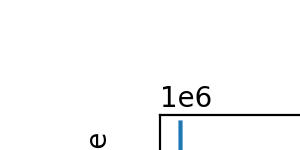

In [16]:
for log in exam_logs:
    Fitter.plot_log(log)

<IPython.core.display.Javascript object>


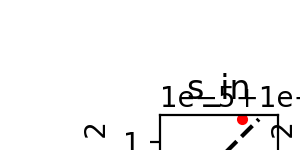

In [17]:
exam_w = exam_posts[exam_ind].w_post(ind_props[exam_ind])
exam_s_in = exam_posts[exam_ind].s_in_post(ind_props[exam_ind]).squeeze()
exam_b_in = exam_posts[exam_ind].b_in_post(ind_props[exam_ind]).squeeze()
exam_s_out = exam_posts[exam_ind].s_out_post(ind_props[exam_ind]).squeeze()
exam_b_out = exam_posts[exam_ind].b_out_post(ind_props[exam_ind]).squeeze()
exam_psi = exam_posts[exam_ind].psi_post.dists[0].mode(ind_props[exam_ind]).squeeze()

exam_mdl = GNLRMdl(m = exam_vi_collections[exam_ind].mdl.m, w=exam_w, s_in=exam_s_in, b_in=exam_b_in, 
                  s_out=exam_s_out, b_out=exam_b_out, psi=exam_psi)

plt.figure()
GNLRMdl.compare_mdls(ind_true_mdls[exam_ind], exam_mdl)

## Look at predicted mean values over the full range of input values for the exam_ind individual

In [18]:
n_exam_smps = 10000

In [19]:
x_exam = torch.randn([n_exam_smps, ind_n_vars[exam_ind]])
#x_exam = ind_data[exam_ind][0]

In [20]:
with torch.no_grad():
    
    # Determine which of our test points are in and out of the training distribution for this individual 
    x_true_proj = ind_true_mdls[exam_ind].project(x_exam).numpy()
    x_true_angles = np.asarray([math.atan2(vl[0], vl[1]) for vl in x_true_proj])
    x_within_train_dist = np.logical_and(x_true_angles > ind_ang_ranges[exam_ind, 0], 
                                         x_true_angles < ind_ang_ranges[exam_ind, 1])
    x_outside_train_dist = np.logical_not(x_within_train_dist)
    
    # Get true mean and predicted mean for each data point for this individual 
    true_mns = ind_true_mdls[exam_ind].m(ind_true_mdls[exam_ind].project(x_exam)).numpy()
    
    x_pred_proj = exam_mdls[exam_ind].project(x=x_exam, w=exam_w, s_in=exam_s_in, b_in=exam_b_in)
    pred_mns = exam_mdls[exam_ind].m(x_pred_proj).numpy()

### Look at point-by-point correspondance

In [21]:
cmp_dim = 2

<IPython.core.display.Javascript object>


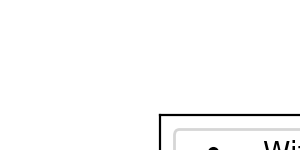

In [22]:
plt.figure()
plt.plot(true_mns[x_within_train_dist, cmp_dim], pred_mns[x_within_train_dist, cmp_dim], 'k.')
plt.plot(true_mns[x_outside_train_dist, cmp_dim], pred_mns[x_outside_train_dist, cmp_dim], 'r.')
plt.legend(['Within Train Dist', 'Outside Train Dist'])


## Look at correspondance of the m functions

### Look at shape of surface of true and predict means as a function of the true low-d projections

<IPython.core.display.Javascript object>


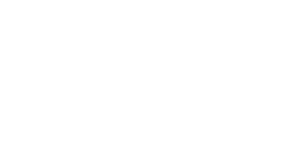

<Axes3DSubplot:>

In [23]:
clrs = np.zeros([n_exam_smps,4])
clrs[:,-1] = 1.0
clrs[x_outside_train_dist, 0] = 1.0

plt.figure()
a = plt.subplot(1,2,1, projection='3d')
plot_three_dim_pts(np.concatenate([x_true_proj, true_mns[:, cmp_dim:cmp_dim+1]], axis=1), 
                   clrs=clrs, a=a)

a = plt.subplot(1,2,2, projection='3d')
plot_three_dim_pts(np.concatenate([x_true_proj, pred_mns[:, cmp_dim:cmp_dim+1]], axis=1), 
                   clrs=clrs, a=a)

### Look at shape of surface of true and predicted means when predicted means are also a function of the predicted low-d projections.

This is a more stringent test of identifiability than the above plots, becuase the learned models could "scramble" the projection to the low-s space and then the learned m-module could sort it out so that mean predictions when viewed as a function from input variables to means is correct, even though the intermediate transformation to low-d variables, and therefore the mapping from low-d variables to means, is not the same as the true models

In [24]:
# Get the estimate low-d projections in the space best aligned to truth

align_vls = align_low_d_spaces(w_0=ind_true_mdls[exam_ind].w.detach().numpy(),
                               s_in_0=ind_true_mdls[exam_ind].s_in.detach().numpy(),
                               b_in_0=ind_true_mdls[exam_ind].b_in.detach().numpy(),
                               w_1=exam_w.detach().numpy(),
                               s_in_1=exam_s_in.detach().numpy(),
                               b_in_1=exam_b_in.detach().numpy(),
                               z_1=x_pred_proj.numpy())

x_pred_proj_aligned = align_vls[-1]

<IPython.core.display.Javascript object>


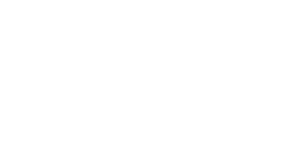

<Axes3DSubplot:>

In [25]:
# Generate plots

plt.figure()
a = plt.subplot(1,2,1, projection='3d')
plot_three_dim_pts(np.concatenate([x_true_proj, true_mns[:, cmp_dim:cmp_dim+1]], axis=1), clrs=clrs, a=a)

a = plt.subplot(1,2,2, projection='3d')
plot_three_dim_pts(np.concatenate([x_pred_proj_aligned, pred_mns[:, cmp_dim:cmp_dim+1]], axis=1), clrs=clrs, a=a)

## Compare true and fit prior distributions over weights

[[ 4.33991276e-01 -7.27448811e-01]
 [ 6.83981162e-01  4.84184673e-01]
 [-1.52066434e-03  7.22798178e-04]]
[[ 0.43399128 -0.72744881]
 [ 0.68398116  0.48418467]]


<IPython.core.display.Javascript object>


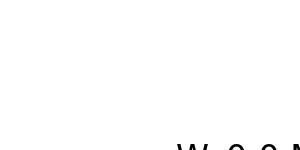

In [26]:
compare_weight_prior_dists(w0_prior=true_priors.w_prior, w1_prior=exam_priors.w_prior, 
                           dim_0_range=[0, 1], dim_1_range=[0, 1], n_pts_per_dim=[200, 200])